### This script performs Gene Ontology (GO) enrichment analysis differentially expressed genes in CRX homeodomain mutant retinas. *All functions are written in R.

In [1]:
# set up the environment
# analysis tools
suppressPackageStartupMessages(library(EnsDb.Mmusculus.v102))
Ensdb <- EnsDb.Mmusculus.v102
suppressPackageStartupMessages((library(org.Mm.eg.db)))
Orgdb <- org.Mm.eg.db
# table processing tools
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(reshape))
suppressPackageStartupMessages((library(clusterProfiler)))
# figure making tools
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(svglite))
suppressPackageStartupMessages(library(extrafont))

[1] "org.Mm.eg.db"         "EnsDb.Mmusculus.v102" "ensembldb"           
 [4] "AnnotationFilter"     "GenomicFeatures"      "AnnotationDbi"       
 [7] "Biobase"              "GenomicRanges"        "GenomeInfoDb"        
[10] "IRanges"              "S4Vectors"            "stats4"              
[13] "BiocGenerics"         "parallel"             "stats"               
[16] "graphics"             "grDevices"            "utils"               
[19] "datasets"             "methods"              "base"

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


[1] "clusterProfiler"      "reshape"              "forcats"             
 [4] "stringr"              "dplyr"                "purrr"               
 [7] "readr"                "tidyr"                "tibble"              
[10] "ggplot2"              "tidyverse"            "org.Mm.eg.db"        
[13] "EnsDb.Mmusculus.v102" "ensembldb"            "AnnotationFilter"    
[16] "GenomicFeatures"      "AnnotationDbi"        "Biobase"             
[19] "GenomicRanges"        "GenomeInfoDb"         "IRanges"             
[22] "S4Vectors"            "stats4"               "BiocGenerics"        
[25] "parallel"             "stats"                "graphics"            
[28] "grDevices"            "utils"                "datasets"            
[31] "methods"              "base"

### 0. Housekeeping

In [16]:
# set the parent directory as working directory
setwd("..")
os.chdir(base_dir)
base_dir = getwd()

In [18]:
# set up directory variables
# Specseq data
spec_basedir = file.path(base_dir, "Specseq_analysis", "processed_data")
# CRX ChIP data
chip_basedir = file.path(base_dir,"ChIPseq_analysis","processed_data")
# CRX RNA data
rna_basedir = file.path(base_dir,"RNAseq_analysis","processed_data")
# Aldiri RNA data
devrna_dir = file.path(base_dir,"RNAseq_analysis","processed_data")
# figure output directory
outbase_dir = file.path(base_dir, "Figures")

In [20]:
# print the entire graphic object to device
save_fig = function(graphicObj, file_name, format='png', width=8, height=8){
    # first check if directory exists, create if not
    dir.create(dirname(file_name), showWarnings = FALSE)
    if(format == "png"){
        png(paste0(file_name,".png"), width = width, height = height)
        print(graphicObj)
    }
    if(format == "svg"){
        svglite(paste0(file_name,".svg"), width = width, height = height)
        print(graphicObj)
    }
    dev.off()
}

### I. load processed tables

In [27]:
# read the processed crx dependent gene tables
crx_dependent_gene <- read.table(file=file.path(rna_basedir, "crx_dependent_genes.tsv"), sep="\t", header=TRUE)

In [28]:
head(crx_dependent_gene, n=4)

,seqnames,start,end,width,chip.r90w.lfc,chip.r90w.fdr,chip_group,strand,gene,distTSS,peak.id,p21.rhom.lfc,p21.rhom.padj,rna_group
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,chr1,193370098,193370498,401,-2.917337,6.854102e-05,Lost,*,Camk1g,0,peak.614,-0.9219836,0.03399652,No Change
2,chr1,161968885,161969285,401,-2.341775,1.821379e-03,Lost,*,Pigc,-143,peak.465,-0.1515740,0.34005166,No Change
3,chr1,39451998,39452398,401,-2.953355,6.346306e-05,Lost,*,Tbc1d8,26557,peak.73,-0.1349072,0.57917740,No Change
4,chr1,183271294,183271694,401,-3.084468,9.975081e-06,Lost,*,Brox,25498,peak.567,0.0702570,0.83775985,No Change


### II. Functions to run GO enrichment analysis and visualize results

In [53]:
GO_enrichement <- function(matrix, ontology="BP", top.n=1000, random.n=NA, padj.method= "BH", q.th=0.05) {
    if (nrow(matrix) < 15){
        print("less than 15 genes in matrix, skipping. return Null")
        return (NULL)
    }else{
        # take only the top.n genes if the genelist length is more than that
        if (length(matrix) > top.n){ #already prearranged by abs(lfc), so gained/loss are both top.n
            matrix <- matrix %>% slice_head(n=top.n)
        }
        # first convert geneID back to entrez ID ...
        IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = matrix$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
        # Run GO enrichment analysis and retrieve results as dataframe
        ego <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = ontology, 
                        pAdjustMethod = padj.method, 
                        qvalueCutoff = q.th, 
                        readable = TRUE) #%>% data.frame()
        
        return(ego)
    }
}

In [59]:
# Dotplot visualization for individual category
clusterProfiler_GO_dotplot <- function(ego.obj, category, age, top.n = 10, save_bool=FALSE, figureout_dir=file.path(outbase_dir, "gene.ontology")){
    if (!is.null(ego.obj)){
        matrix <- ego.obj %>% data.frame() %>% dplyr::slice_head(n=top.n) %>% arrange(desc(p.adjust))
        GO.term <- ego.obj@ontology
        file.name <- file.path(figureout_dir, paste0(age, ".", category, ".", GO.term, ".top", top.n, ".png"))
        print(paste("drawing",category, GO.term, ".top", top.n))
        if (nrow(matrix)>0){
            if (save_bool) {
            png(file.name, width=800, height=400, unit="px", bg="#ffffff")
            print(dotchart(-log(matrix$p.adjust, base=10), labels=matrix$Description, xlab = "Hyper_Adjp_BH", main = paste(age, "top", GO.term, "terms\nat", str_replace(category, "_", " "), "genes")))
            dev.off()
            }
            print(dotchart(-log(matrix$p.adjust, base=10), labels=matrix$Description, xlab = "Hyper_Adjp_BH", main = paste(age, "top", GO.term, "terms\nat", str_replace(category, "_", " "), "genes")) + xlim(0,round(max(-log(matrix$p.adjust, base=10))+0.5)))
            }
        else{print("no enriched category found")}

    }else{
        print("less than 15 genes in the category, GO analysis was not run")
    }    
}

### III. GO analysis for CRX dependent and independent gene sets (Extended Data Fig. 4)

#### a. CRX-dependent activated gene set

In [ ]:
# retrieve gene name and entrezid
crx_Dact_genes <- crx_dependent_gene %>% arrange(desc(p21.rhom.lfc)) %>% filter(rna_group == "Lost") 
IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = crx_Dact_genes$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
# attach fold change column
IDto.entrez$fold <- all_lfc$p21.rhom.lfc[match(IDto.entrez$GENENAME, all_lfc$gene)]

# run GO enrichment analysis on genelist
crx_Dact_GO <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

# use simplify to remove redundant terms
simp_crx_Dact_GO <- simplify(crx_Dact_GO, cutoff=0.7, by="p.adjust", select_fun=min)

# check top10 terms
clusterProfiler_GO_dotplot(simp_crx_Dact_GO, "BP", "p21", top.n = 10, save_bool=FALSE)

In [65]:
file.name <- file.path(rna_basedir, "gene.ontology", "crx_depAct_genes.tsv")
simp_crx_Dact_GO %>% data.frame() %>% arrange(p.adjust) %>% write.table(file=file.name, sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)

#### b. CRX-independent gene set

[1] "drawing BP BP .top 10"
NULL


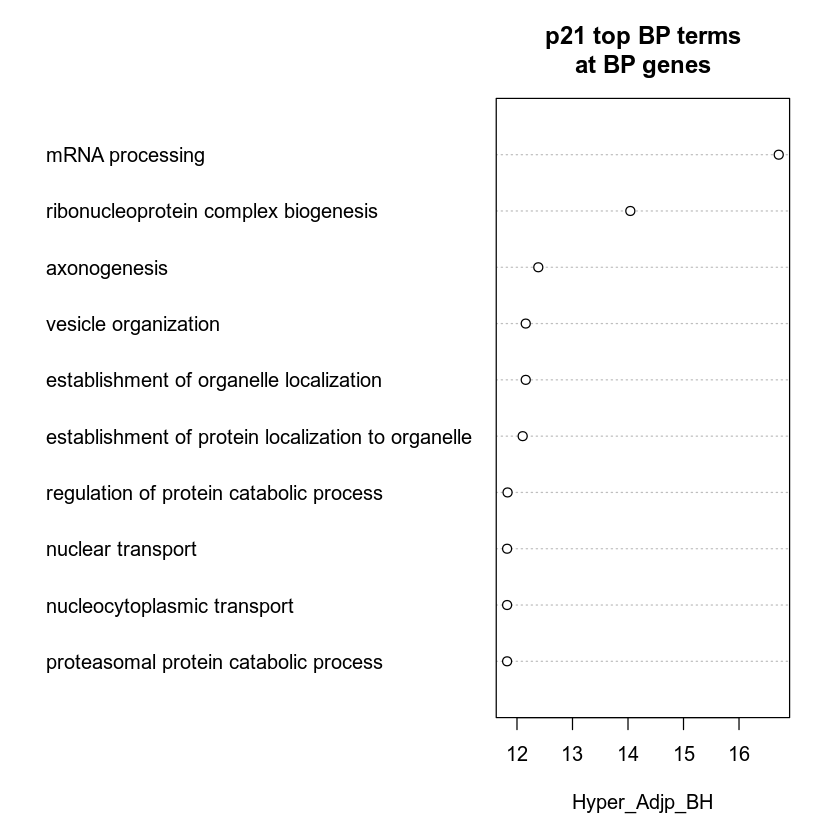

In [66]:
# retrieve gene name and entrezid
crx_Ind_genes <- crx_dependent_gene %>% arrange(desc(p21.rhom.lfc)) %>% filter(rna_group == "No Change") 
IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = crx_Ind_genes$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
# attach fold change column
IDto.entrez$fold <- all_lfc$p21.rhom.lfc[match(IDto.entrez$GENENAME, all_lfc$gene)]

# run GO enrichment analysis on genelist
crx_Ind_GO <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

# use simplify to remove redundant terms
simp_crx_Ind_GO <- simplify(crx_Ind_GO, cutoff=0.7, by="p.adjust", select_fun=min)

# check top10 terms
clusterProfiler_GO_dotplot(simp_crx_Ind_GO, "BP", "p21", top.n = 10, save_bool=FALSE)

In [67]:
file.name <- file.path(rna_basedir, "gene.ontology", "crx_independent_genes.tsv")
simp_crx_Ind_GO %>% data.frame() %>% arrange(p.adjust) %>% write.table(file=file.name, sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)

### IV. GO analysis for subset of genes in CRX-independent category that show differential expression in HD mutants (Extended Data Fig. 5)

#### a. $Crx^{E80A}$ mutants

In [68]:
p10.e80a.independentGenes <- read.table(file=file.path(rna_basedir, "p10_e80a_independentGenes_bindingIntensity.tsv"), sep="\t", header=TRUE)
#drop duplicates and then split into gain and lost
p10.e80a.independentGenes <- p10.e80a.independentGenes %>% dplyr::distinct(gene, .keep_all= TRUE)
p10.e80a.ind.gainGenes <- p10.e80a.independentGenes %>% dplyr::filter(subgroup=="group1")
p10.e80a.ind.lostGenes <- p10.e80a.independentGenes %>% dplyr::filter(subgroup=="group2")

[1] "drawing BP BP .top 20"
NULL


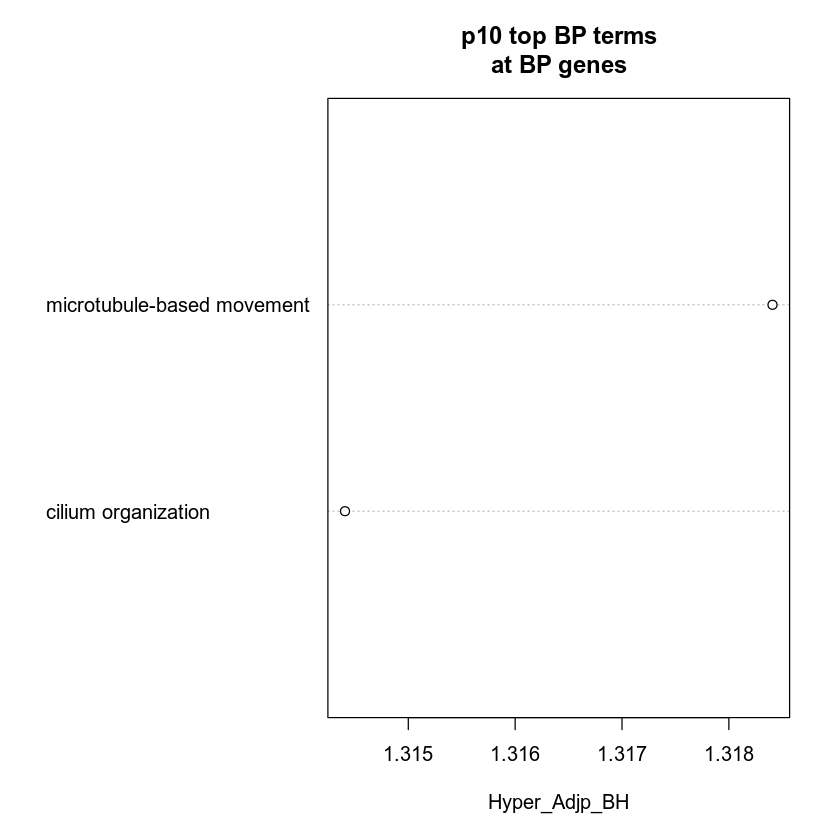

In [69]:
# retrieve gene name and entrezid
IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = p10.e80a.ind.gainGenes$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
# run GO analysis
p10.e80a.ind.gainGenes_GO <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        qvalueCutoff = 0.1, 
                        readable = TRUE)

clusterProfiler_GO_dotplot(p10.e80a.ind.gainGenes_GO, "BP", "p10", top.n = 20, save_bool=FALSE)

In [70]:
# retrieve gene name and entrezid
IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = p10.e80a.ind.lostGenes$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
# run GO analysis
p10.e80a.ind.lostGenes_GO <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        qvalueCutoff = 0.1, 
                        readable = TRUE)

clusterProfiler_GO_dotplot(p10.e80a.ind.lostGenes_GO, "BP", "p10", top.n = 20, save_bool=FALSE)

[1] "drawing BP BP .top 20"
[1] "no enriched category found"


#### b. $Crx^{K88N}$ mutants

In [71]:
p10.k88n.independentGenes <- read.table(file=file.path(rna_basedir, "p10_k88n_independentGenes_bindingIntensity.tsv"), sep="\t", header=TRUE)
#drop duplicates and then split into gain and lost
p10.k88n.independentGenes <- p10.k88n.independentGenes %>% dplyr::distinct(gene, .keep_all= TRUE)
p10.k88n.ind.gainGenes <- p10.k88n.independentGenes %>% dplyr::filter(subgroup=="group1")
p10.k88n.ind.lostGenes <- p10.k88n.independentGenes %>% dplyr::filter(subgroup=="group2")

In [72]:
# retrieve gene name and entrezid
IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = p10.k88n.ind.gainGenes$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
# run GO analysis
p10.k88n.ind.gainGenes_GO <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        qvalueCutoff = 0.1, 
                        readable = TRUE)

clusterProfiler_GO_dotplot(p10.k88n.ind.gainGenes_GO, "BP", "p10", top.n = 20, save_bool=FALSE)

[1] "drawing BP BP .top 20"
[1] "no enriched category found"


[1] "drawing BP BP .top 20"
NULL


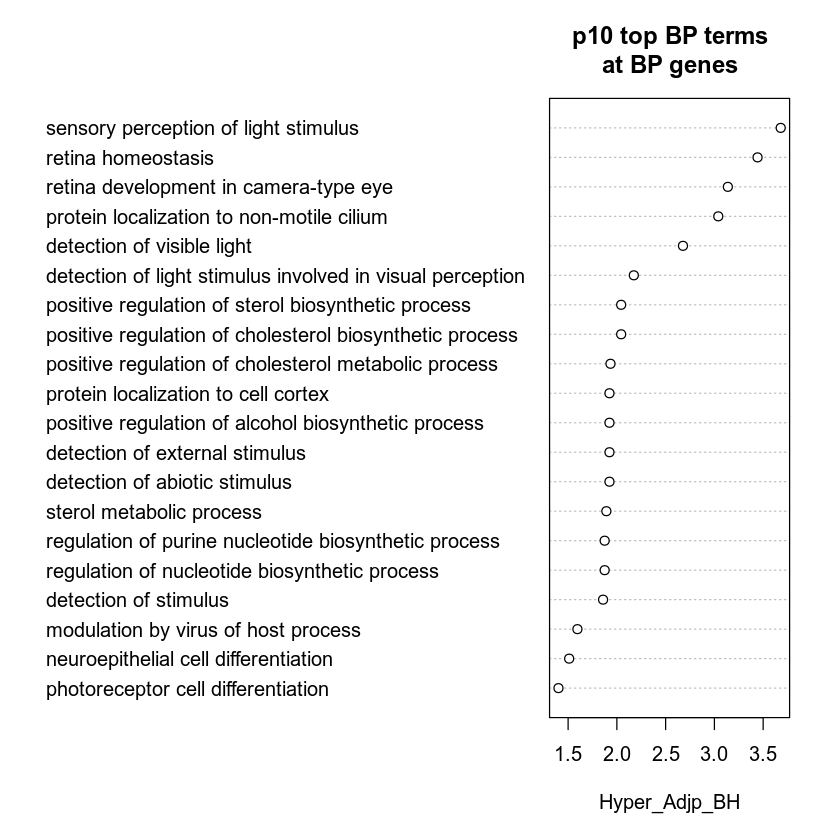

In [73]:
# retrieve gene name and entrezid
IDto.entrez <- AnnotationDbi::select(Ensdb,
                                    keys = p10.k88n.ind.lostGenes$gene,
                                    keytype="GENENAME",
                                    columns="ENTREZID"
                                    )
# run GO analysis
p10.k88n.ind.lostGenes_GO <- enrichGO(gene = IDto.entrez$ENTREZID, 
                        keyType = "ENTREZID", 
                        OrgDb = Orgdb, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        qvalueCutoff = 0.1, 
                        readable = TRUE)

# use simplify to remove redundant terms
simp_p10.k88n.ind.lostGenes_GO <- simplify(p10.k88n.ind.lostGenes_GO, cutoff=0.7, by="p.adjust", select_fun=min)

clusterProfiler_GO_dotplot(simp_p10.k88n.ind.lostGenes_GO, "BP", "p10", top.n = 20, save_bool=FALSE)

In [76]:
saveRDS(p10.k88n.ind.lostGenes_GO, file=file.path(rna_basedir, "gene.ontology", "p10.k88n.ind.lostGenes_GO.rds"))

In [77]:
file.name <- file.path(rna_basedir, "gene.ontology", "p10.k88n.ind.lostGenes.tsv")
simp_p10.k88n.ind.lostGenes_GO %>% data.frame() %>% arrange(p.adjust) %>% write.table(file=file.name, sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)